# FSB: Filtered-Squared Bispectra

In [1]:
from fsb import *
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

## Data

In [2]:
# let's make some non-gaussian maps 

nside = 256
npix = hp.nside2npix(nside)

def generate_map(cl):

    """
    This function generates a non-gaussian map from a given power 
    spectrum using Lagrangian Perturbation Theory on the 2D sphere
    (Alonso et al. 2015: https://arxiv.org/abs/1512.03402).
    """

    alm = hp.synalm(cl, lmax=3*nside-1)
    
    ls = np.arange(3*nside)
    fl = np.sqrt((ls+2)*(ls+1)*ls*(ls-1))/(ls*(ls+1))
    fl[:2] = 0
    
    elm = hp.almxfl(alm, fl)
    delta = hp.alm2map(alm, nside)
    
    Q, U = hp.alm2map_spin([elm, 0*elm], nside=nside, spin=2, lmax=3*nside-1)

    H11 = 1+0.5*(delta+Q)
    H22 = 1+0.5*(delta-Q)
    H12 = 0.5*U

    return H11*H22-H12**2-1


In [3]:
import pyccl as ccl
import scipy.stats as st

# multipole range
ells = np.arange(3*nside)

# a realistic survey redshift distribution
z = np.linspace(0.005, 1, 100)
dndz = st.lognorm.pdf(z, 0.4, loc=0.35, scale=.2)

# generate cosmology
cosmo = ccl.CosmologyVanillaLCDM()
bias = 2.0
bz = np.ones_like(z)*bias
tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, dndz), bias=(z, bz))

# compute angular power spectrum
some_standard_cls = ccl.angular_cl(cosmo, tracer, tracer, ells)

In [4]:
# non-gaussian overdensity map
delta = generate_map(some_standard_cls)
delta_cls = hp.anafast(delta) # and corresponding cls (for plotting)

/tmp/ipykernel_3412053/3486926515.py:17: RuntimeWarning: invalid value encountered in divide
  fl = np.sqrt((ls+2)*(ls+1)*ls*(ls-1))/(ls*(ls+1))


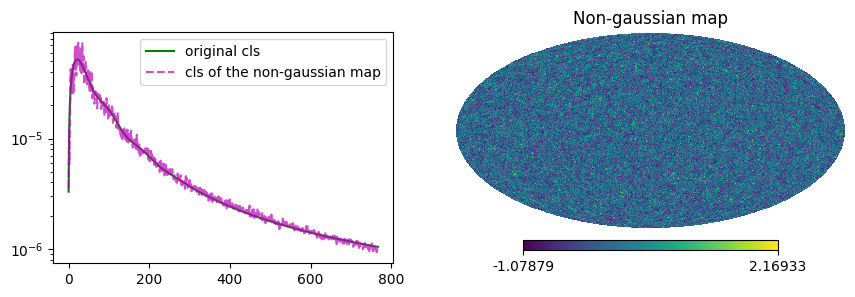

In [5]:
# plotting cls and non-gaussian map
import matplotlib.gridspec as gs

plt.figure(figsize=(11,3))
grid = gs.GridSpec(1,2, width_ratios=[2,3], wspace=0.005)
ax0 = plt.subplot(grid[0])
ax0.semilogy(ells, some_standard_cls, 'g-', label='original cls')
ax0.semilogy(ells, delta_cls, 'm--', label='cls of the non-gaussian map', alpha=0.7)
ax0.legend(loc='upper right')
ax1 = plt.subplot(grid[1])
hp.mollview(delta, hold=True, title='Non-gaussian map')

## FSB signal

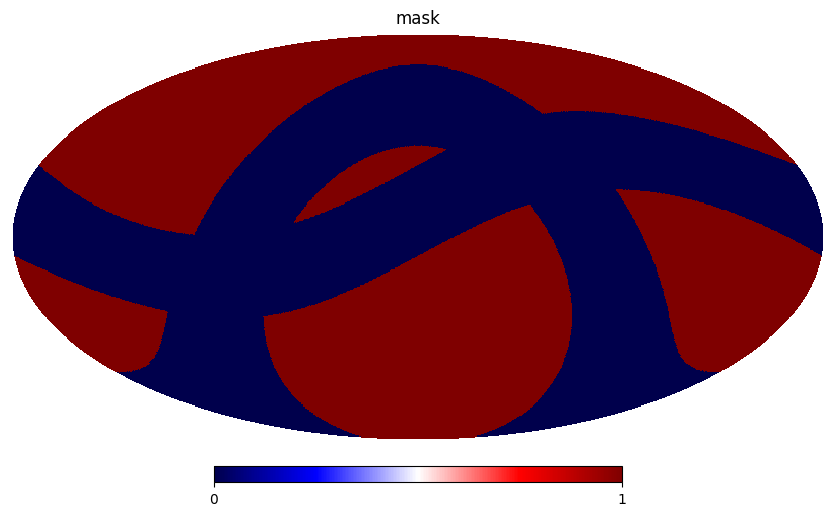

In [6]:
# defining some parameters

# FSB filters
nbands = 5
fls = get_filters(nbands, nside)

# ells per bin
lpb = 17

# a realistic survey mask
mask = np.ones(hp.nside2npix(nside))
mask[hp.query_strip(nside, 30, 90)] = 0 # mask the galactic plane
mask = hp.Rotator(coord='GC').rotate_map_pixel(mask)
mask[hp.query_strip(nside, 20, 80)] = 0 # mask the ecliptic plane
mask = hp.Rotator(coord='CE').rotate_map_pixel(mask)
mask = mask>0 # ensure the mask is binary

hp.mollview(mask, cmap='seismic', title='mask')

In [7]:
# initiating FSB class, which will contain all quantities needed to compute the FSB and its covariance
delta = (delta-np.mean(delta[mask==1]))*mask # - mean inside mask
fsb_test = FSB(delta, mask1=mask, filters=fls, ells_per_bin=lpb)

(5, 45)


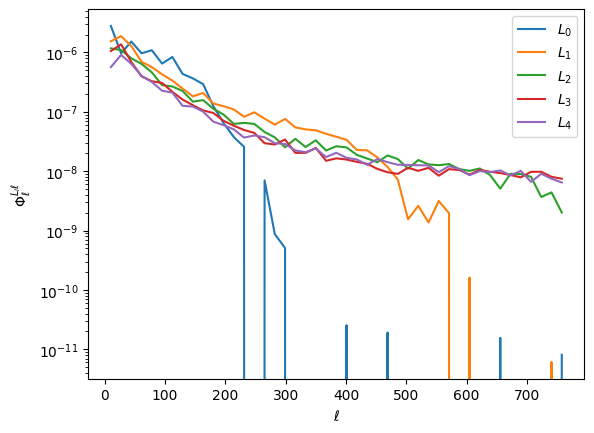

In [8]:
# let's plot the fsb
print(fsb_test.fsb_binned.shape) # 5 filters, 45 datapoints (bins)

for i, f in enumerate(fsb_test.fsb_binned):
    plt.semilogy(fsb_test.bb.get_effective_ells(), f, label=r'$L_{0}$'.format(i))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Phi_\ell^{L_i \ell}$')
plt.legend()

## FSB covariance

In [9]:
# simulation-based

# for this we need to generate several realisations of our original non-gaussian map:
nsims = 100
mapsims = np.zeros((nsims, npix))
# then we compute the FSB for each simulated map
fsbsims = np.zeros((nsims, nbands+1, fsb_test.b))
for s in range(nsims):
    if s%10==0: 
        print(s)
    ds = generate_map(some_standard_cls)
    mapsims[s] = (ds-np.mean(ds[mask==1]))*mask 
    fsb_s = FSB(mapsims[s], mask1=mask, filters=fls, ells_per_bin=lpb)
    fsbsims[s, :nbands] = fsb_s.fsb_binned
    fsbsims[s, -1:] = fsb_s.cls_binned 

# compute the covariance

# reduce dimension so we can compute the covariance
fsbsims_flat = np.array([l.flatten() for l in fsbsims])
# compute covariance from simulations
simcov = np.cov(fsbsims_flat.T)
print(simcov.shape, fsbsims_flat.shape)


0


/tmp/ipykernel_3412053/3486926515.py:17: RuntimeWarning: invalid value encountered in divide
  fl = np.sqrt((ls+2)*(ls+1)*ls*(ls-1))/(ls*(ls+1))


10
20
30
40
50
60
70
80
90
(270, 270) (100, 270)


In [10]:
# analytical covariance 
# (includes disconnected covariance + non gaussian terms N222 and N32)
anacov = fsb_test.get_full_cov() # as simple as that (may take a while though)

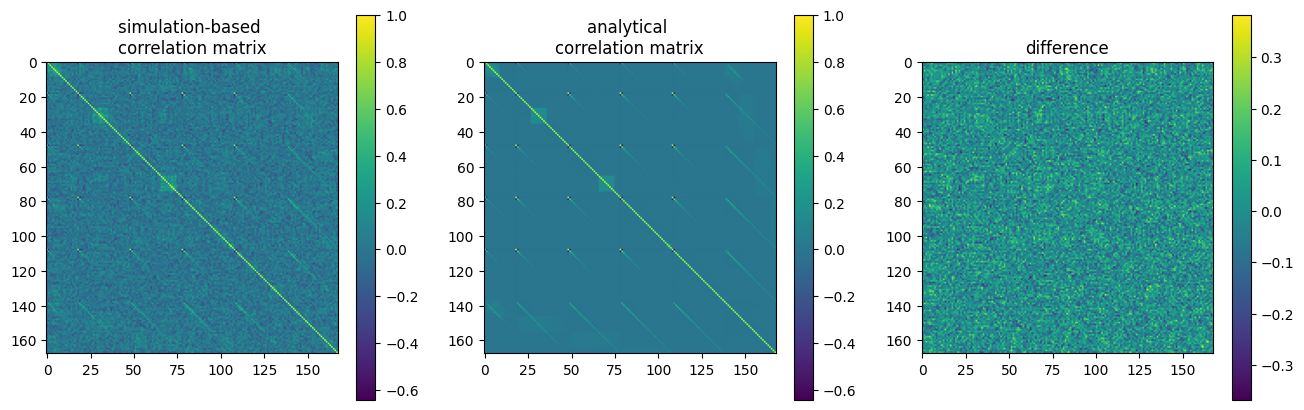

In [11]:
def fixflatm(m):

    """
    This function removes all indices that corresponds to:
    - a multipole range where the SHT is not reliable (>2*nside)
    - a multipole range where triangles cannot be formed
      (ell1 + ell2 >= ell3 not satisfied)
    The values below are specific to this example! a different 
    number of filters/bandpowers will lead to different limits.
    """

    until = 30 # corresponds to bandpower > 2*nside
    nbins = 45
    ind_to_del = np.array([np.arange((i)*nbins+until, (i+1)*nbins) 
                           for i in range(nbands+1)]).flatten()
    # the 18th bandpower corresponds to the range where triangles
    # cannot be formed in the first filter, by the triangle inequality
    ind_to_del = np.concatenate((np.arange(18, until), ind_to_del))

    newm = np.delete(m, ind_to_del, axis=0)
    newm = np.delete(newm, ind_to_del, axis=1)

    return newm


def cor(cov):
    
    """
    This function returns the correlation matrix
    corresponding to the covariance matrix.
    """

    return cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov)))  



plt.figure(figsize=(16,5))

simcor = fixflatm(cor(simcov))
anacor = fixflatm(cor(anacov))
mini = min(np.min(simcor), np.min(anacor))
maxi = max(np.max(simcor), np.max(anacor))

plt.subplot(131)
plt.imshow(simcor, vmin=mini, vmax=maxi)
plt.title('simulation-based \ncorrelation matrix')
plt.colorbar()
plt.subplot(132)
plt.imshow(anacor, vmin=mini, vmax=maxi)
plt.title('analytical \ncorrelation matrix')
plt.colorbar()
plt.subplot(133)
plt.imshow(simcor-anacor)
plt.title('difference')
plt.colorbar(); 

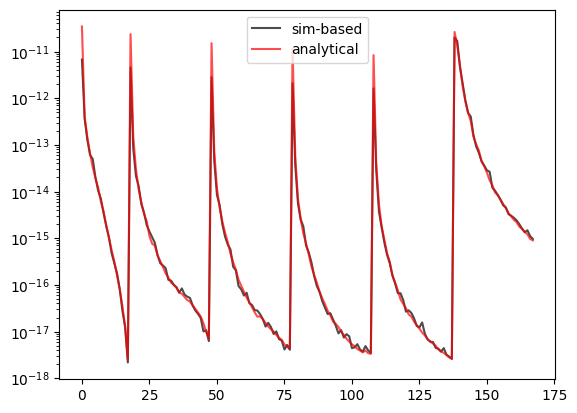

In [12]:
# plotting the main diagonal of the covariance matrix
plt.semilogy(np.diag(fixflatm(simcov)), 'k-', alpha=0.7, label='sim-based')
plt.semilogy(np.diag(fixflatm(anacov)), 'r-', alpha=0.7, label='analytical')
plt.legend(); 